# 프로젝트: 인물 모드 문제점 찾기

## Step 1. 인물모드 직접 해 보기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

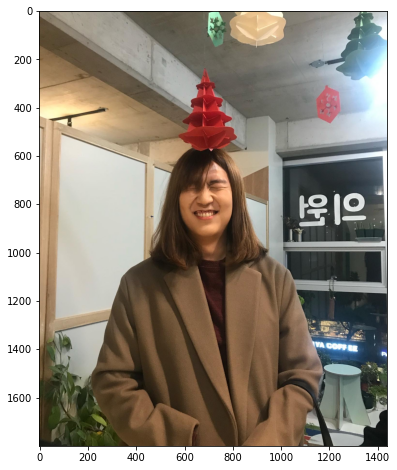

In [2]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/aiffel_quest/quest_exp_05/itsme.jpeg'  
img_orig = cv2.imread(img_path) 

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# 모델 다운로드
model_dir = os.getenv('HOME')+'/aiffel/aiffel_quest/quest_exp_05/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
os.makedirs(model_dir, exist_ok=True)
urllib.request.urlretrieve(model_url, model_file)


('/aiffel/aiffel/aiffel_quest/quest_exp_05/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f17bd4e5370>)

In [4]:
# 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

LABEL2ID = {label: i for i, label in enumerate(LABEL_NAMES)}
LABEL2ID

{'background': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tv': 20}

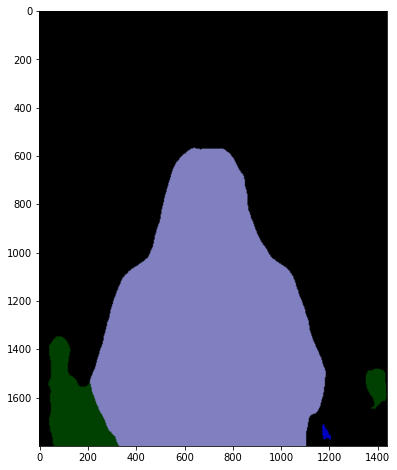

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(output)
plt.show()

In [8]:
# segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person
pottedplant


In [9]:
# 컬러맵 만들기 
COLORMAP = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        COLORMAP[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

COLORMAP[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [10]:
seg_color = tuple(COLORMAP[LABEL2ID['person']][::-1])

(1800, 1440)


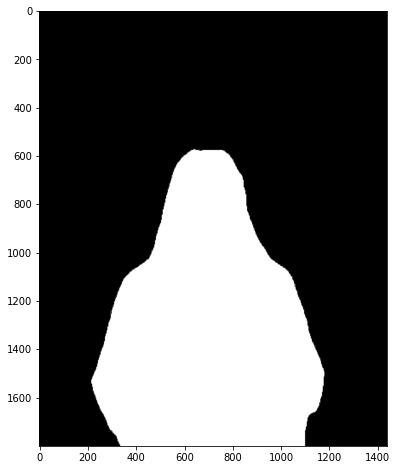

In [11]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.figure(figsize=(8,8))
plt.imshow(seg_map, cmap='gray')
plt.show()

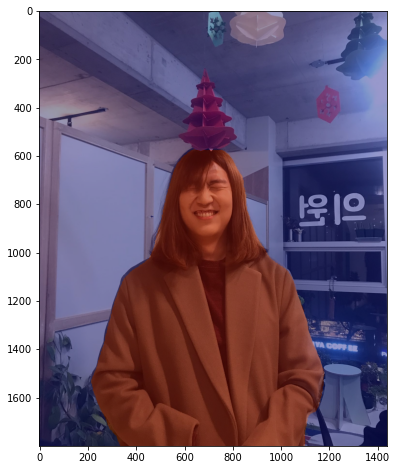

In [12]:
# 원본이미지에 마스크 표시
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255 # True, False를 255, 0으로 변경

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

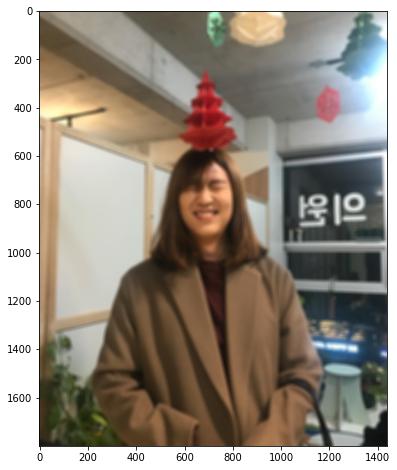

In [13]:
# 블러 이미지 생성
img_orig_blur = cv2.blur(img_orig, (18,18))
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

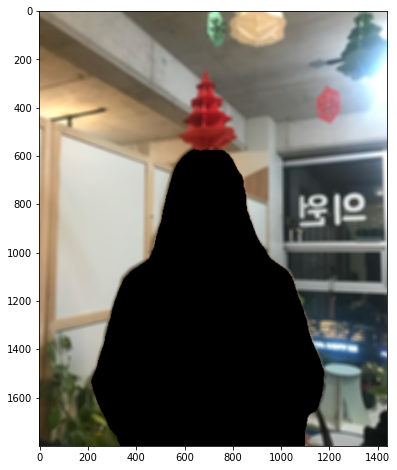

In [14]:
# 블러 이미지에 마스크 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

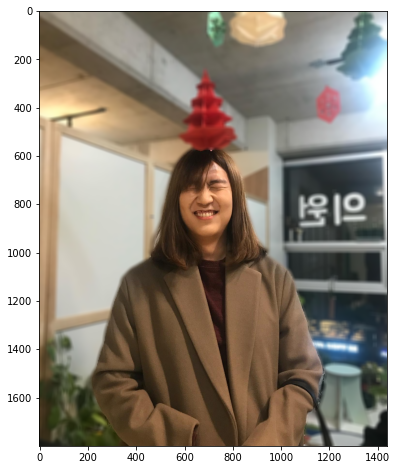

In [15]:
# 블러 이미지에 원본 이미지 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
# 위 작업을 함수화. 이미지와 대상을 입력하면 대상을 중심으로 아웃포커싱한 이미지를 출력
def get_blurred_image(img_path, obj):
    img_orig = cv2.imread(img_path) 
    try:
        index = LABEL2ID[obj]
    except:
        print('Wrong object name')
        return
    
    segvalues, output = model.segmentAsPascalvoc(img_path)

    if index in segvalues['class_ids']:
        seg_color = tuple(COLORMAP[index][::-1])
    else:
        print('Object not detected')
        return
    
    seg_map = np.all(output==seg_color, axis=-1) 
    
    img_show = img_orig.copy()
    img_mask = seg_map.astype(np.uint8) * 255

    img_orig_blur = cv2.blur(img_orig, (30,30))
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    
    img_concat = np.where(img_mask_color==255, img_orig, img_orig_blur)

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()


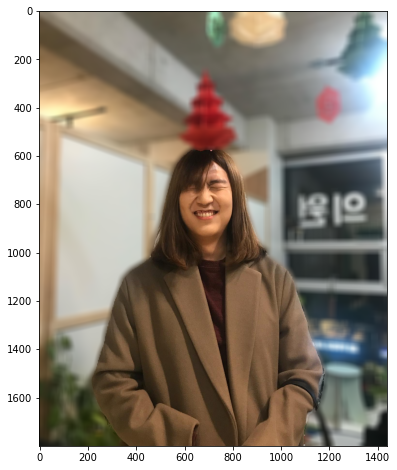

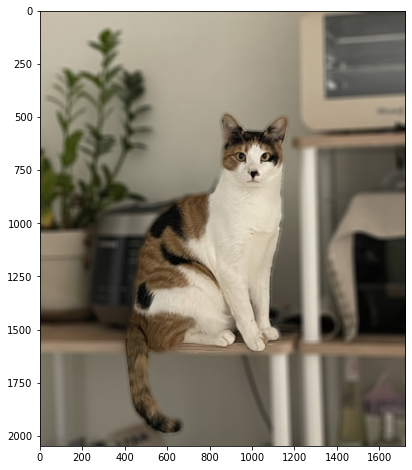

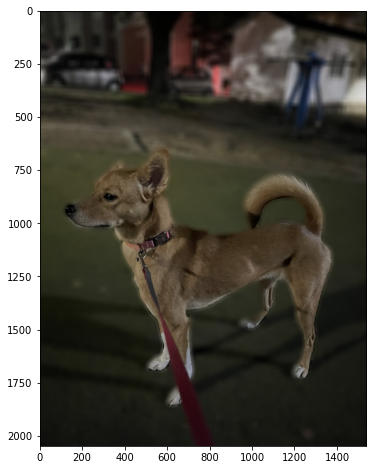

In [17]:
img_path_me = os.getenv('HOME')+'/aiffel/aiffel_quest/quest_exp_05/itsme.jpeg'
img_path_cat = os.getenv('HOME')+'/aiffel/aiffel_quest/quest_exp_05/chichi.jpeg' 
img_path_dog = os.getenv('HOME')+'/aiffel/aiffel_quest/quest_exp_05/molly.jpeg'  

get_blurred_image(img_path_me, 'person')
get_blurred_image(img_path_cat, 'cat')
get_blurred_image(img_path_dog, 'dog')

In [18]:
# 색상 반전 효과
def get_negative_image(img_path, obj, bg_neg=True):
    img_orig = cv2.imread(img_path) 
    try:
        index = LABEL2ID[obj]
    except:
        print('Wrong object name')
        return
    
    segvalues, output = model.segmentAsPascalvoc(img_path)

    if index in segvalues['class_ids']:
        seg_color = tuple(COLORMAP[index][::-1])
    else:
        print('Object not detected')
        return
    
    seg_map = np.all(output==seg_color, axis=-1) 
    
    img_show = img_orig.copy()
    img_mask = seg_map.astype(np.uint8) * 255

    img_orig_neg = cv2.bitwise_not(img_orig)
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
        
    if bg_neg == True:
        img_concat = np.where(img_mask_color==255, img_orig, img_orig_neg)
    else:
        img_concat = np.where(img_mask_color==255, img_orig_neg, img_orig)

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

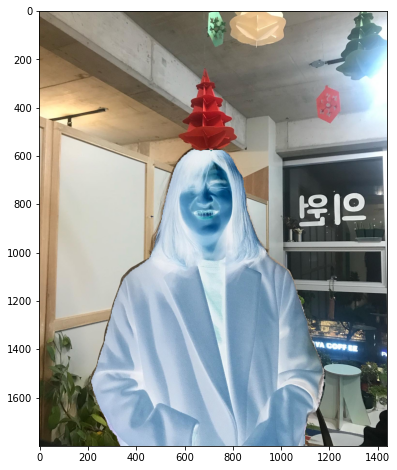

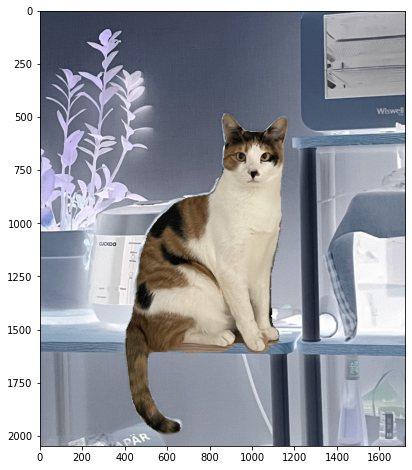

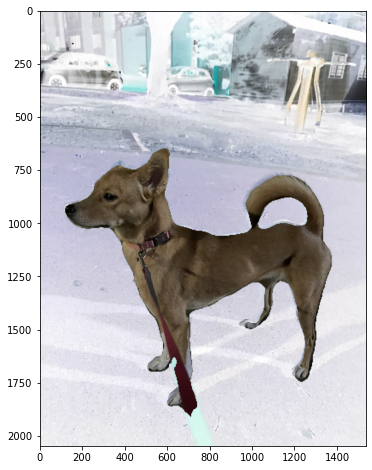

In [19]:
get_negative_image(img_path_me, 'person', bg_neg=False)
get_negative_image(img_path_cat, 'cat')
get_negative_image(img_path_dog, 'dog')

## Step 2. 사진에서 문제점 찾기

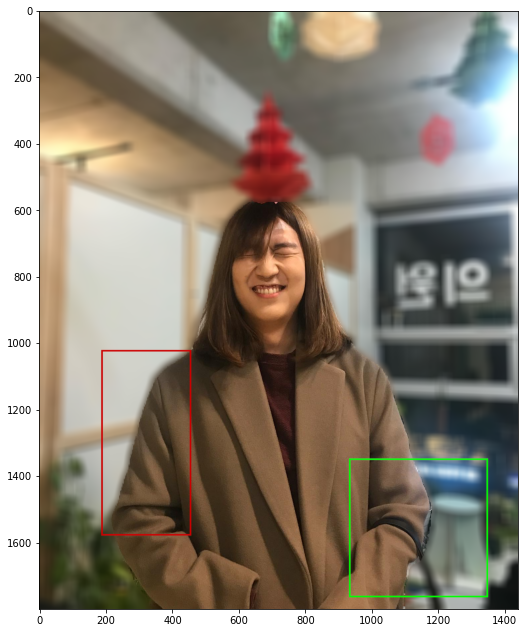

In [20]:
img_error_path = os.getenv('HOME')+'/aiffel/aiffel_quest/quest_exp_05/itsme_blurred_error.png'  
img_error = cv2.imread(img_error_path)

plt.figure(figsize=(11,11))
plt.imshow(cv2.cvtColor(img_error, cv2.COLOR_BGR2RGB))
plt.show()

- 인물과 배경 경계선에서 블러 효과가 발생한다(붉은 사각형).
- 인물의 소지품 일부는 블러 처리되고 일부는 그대로다(녹색 사각형).


## Step 3. 해결 방법을 제안해 보기

- 인물과 배경의 경계선에서 블러 효과가 적용되는 이유는 인물의 외곽선 주변부를 배경으로 인식하기 때문이다. 이미지를 3d로 인식할 수 있다면 외곽선 주변부에서 카메라와의 거리가 가까운 부분은 인물로, 먼 부분은 배경으로 인식함으로써 인물의 경계를 명확하게 설정할 수 있을 것이다. 

## 회고
- 이미지에 인물 모드 효과를 적용하는 것은 다음과 같은 과정으로 이루어진다.
    - 이미지에서 인물 인식(semantic segmantation)
    - 인물에 해당하는 영역만 마스킹
    - 원본 이미지에 블러 효과가 적용된 새 이미지 생성
    - 마스킹이 된 영역은 원본 이미지를, 그 외 영역은 블러 이미지를 입힌 최종 이미지 생성 및 출력
- 이번에 사용한 semantic segmantation 모델은 20개의 대상을 인식할 수 있는데, 임의로 제시된 대상을 인식할 수 있는 모델을 만들 수는 없을까?
- 이미지를 3d로 인식할 수 있다면 이미지 속 대상을 더 정교하게 인식하고 분리할 수 있을 것이다.